### After talking w/ Professor, we figured out that we should make our input that each row represents one question, and each column represents one person. Therefore, instead of a dimension - reduction version of DMD (in the people_questions because the row number is large), we do an actual DMD below. In this case, each entry of eigenvector corresponds to the weight of each question. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from datetime import datetime, date

In [2]:
## Import data set
clean1_filepath = 'SET data archive 3416 cases recd thru end of 03 2019_cleaned_general.csv'

df = pd.read_csv(clean1_filepath)
df.head()

,Unnamed: 0,UniqueID,no_intake_question,no_retest1_question,no_retest2_question,SET_program_num,ETO_PROGRAM,SET_admin_num,baseline_type,enroll_SET_type_num,...,Completed_by_CIW,CIW_CLIENT_ID,CIW_INTERVIEW_DATE,CIW_COMPLETED_DATE,CIW1,CIW2,CIW3,CIW4,CIW5,CIW6_COMMENTS
0,3,49866,,,,1,1,1,,,...,999,,,,1.0,4.0,4.0,1.0,3.0,Client's son is helping him to change little b...
1,4,49868,,,,1,1,1,,,...,999,,,,2.0,3.0,4.0,1.0,3.0,Slow progress
2,5,49870,,,,1,1,1,,,...,999,,,,2.0,3.0,3.0,1.0,3.0,She goes there a lot ?home? She is trying to c...
3,8,47002,,,,1,1,1,,,...,999,Southwest 2-23-230-1,9/13/2018,9/13/2018,2.0,3.0,1.0,4.0,0.0,Client has been attending program and is stayi...
4,13,41570,,,,2,2,1,,1,...,999,SSSEARE-0-100-1,,,NaN,NaN,NaN,NaN,NaN,no page 17 completed


In [3]:
#drop old indexing column
df = df.drop(df.columns[0], axis=1)

#### Continued - June 9, 2019

### DMD Dataframe

#### Reduce dataframe to include attitudinal/behaviorial questions w/ numeric responses for DMD

In [4]:
que = (['UniqueID'])
que.extend(df.loc[:,'intake':'retest'].columns.tolist())
que.extend(df.loc[:,'GRYD_Zone_num':'INTERVIEW_DATE_FB'].columns.tolist())
que.extend(df.loc[:,'ENROLLMENT_DATE_1':'SEX_1'].columns.tolist())

In [5]:
# S SECTION
# Not included because we don't know how to evaluate
# que = df.loc[:,'S1':'S3'].columns.tolist()
# que.extend(df.loc[:,'S4x':'S6ax'].columns.tolist())

# showcard1 
que.extend(df.loc[:,'S9':'S10'].columns.tolist())
que.extend(df.loc[:,'S10x':'S11a'].columns.tolist())
que.extend(['S11b'])
que.extend(df.loc[:,'S12':'S16'].columns.tolist()) #attitudinal

# ME SECTION 
# not scored properly
que.extend(df.loc[:,'ME17':'ME22_ER'].columns.tolist())

#P SECTION (attitudinal but not scored properly)
que.extend(df.loc[:,'P22':'P26'].columns.tolist())

# C SECTION 
# Not included because behavioral
# que.extend(['C1a','C2a','C3a','C4a','C5a'])

# FS SECTION 
# Not included because we don't know how to evaluate / not including family section
# que.extend(df.loc[:,'FS89_foster_now':'FS89_alone_past'].columns.tolist())

# F SECTION
# Not included because we don't know how to evaluate 
# didn't include family portion on YSET , so to compare we won't include it here
# que.extend(df.loc[:,'F1':'F3'].columns.tolist())
# que.extend(df.loc[:,'F4':'F5'].columns.tolist())
# que.extend(df.loc[:,'FS91':'FS98'].columns.tolist())
# que.extend(df.loc[:,'FS100':'F17x'].columns.tolist())
# que.extend(df.loc[:,'F18':'F31b'].columns.tolist())

# G SECTION
# don't include group section
# que.extend(df.loc[:,'G2':'G3a'].columns.tolist())
# que.extend(['EG1'])
# que.extend(df.loc[:,'EG3':'G7'].columns.tolist())
# que.extend(df.loc[:,'G8':'G9'].columns.tolist())
# que.extend(df.loc[:,'G10x':'G23x'].columns.tolist())
# que.extend(df.loc[:,'G24':'G36b'].columns.tolist())
# que.extend(['G37'])

# X SECTION
que.extend(df.loc[:,'X18':'X22'].columns.tolist())

#que.extend(['A1','A2','A3'])

# O SECTION
#don't include other group section
#o_que = df.loc[:,'O4':'O7x'].columns.tolist()
#o_que.extend(df.loc[:,'O8':'O9'].columns.tolist())
#o_que.extend(df.loc[:,'O10':'O15'].columns.tolist())
#o_que.extend(df.loc[:,'O16':'O24'].columns.tolist())
#que.extend(o_que)

# X section
#que.extend(df.loc[:,'X10':'X15'].columns.tolist())
#don't include because behavioral related to drugs/ac/violence (section equivalent to IJ on YSET)
#que.extend(df.loc[:,'X16':'X17'].columns.tolist())

In [6]:
print(que)

['UniqueID', 'intake', 'retest', 'GRYD_Zone_num', 'INTERVIEW_DATE_FB', 'ENROLLMENT_DATE_1', 'AGE_1_FB', 'SEX_1', 'S9', 'S10', 'S10x', 'S10z', 'S11a', 'S11b', 'S12', 'S13', 'S14', 'S16', 'ME17', 'ME18', 'ME19', 'ME20a', 'ME20b', 'ME20x', 'ME22_ER', 'P22', 'P23', 'P24', 'P25', 'P26', 'X18', 'X19', 'X20', 'X21', 'X22']


In [7]:
#create new dataframe for DMD with these kept columns
df_dmd = df.filter(que, axis=1)
df_dmd.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
0,49866,1,777,14,3/15/2019,3/6/2019,22,1,3.0,0.0,...,4.0,4.0,2.0,2.0,5.0,1.0,0.0,1.0,1.0,1.0
1,49868,1,777,14,3/15/2019,3/7/2019,23,1,3.0,0.0,...,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2,49870,1,777,14,3/14/2019,3/6/2019,25,2,3.0,0.0,...,5.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0
3,47002,1,777,23,9/13/2018,9/4/2018,18,2,0.0,0.0,...,3.0,3.0,3.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0
4,41570,1,777,999,10/25/2017,10/6/2017,16,1,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,0.0


In [8]:
ind = df_dmd.index.tolist()

### Fix sections/questions that aren't scored properly -- July 10,2019

The higher score should mean the higher the risk. Questions that we have included that aren't scored properly are:
ME18,
ME20x,
P24,
P25

In [9]:
#fix score scaling for question ME18
for i in ind:
    entry = df_dmd.loc[i,'ME18']
    if entry == 1.0:
        df_dmd.loc[i,'ME18'] = 5.0
    elif entry == 2.0:
        df_dmd.loc[i,'ME18'] = 4.0
    elif entry == 4.0:
        df_dmd.loc[i,'ME18'] = 2.0
    elif entry == 5.0:
        df_dmd.loc[i,'ME18'] = 1.0
        
#fix score scaling for question ME20x
for i in ind:
    entry = df_dmd.loc[i,'ME20x']
    if entry == 1.0:
        df_dmd.loc[i,'ME20x'] = 5.0
    elif entry == 2.0:
        df_dmd.loc[i,'ME20x'] = 4.0
    elif entry == 4.0:
        df_dmd.loc[i,'ME20x'] = 2.0
    elif entry == 5.0:
        df_dmd.loc[i,'ME20x'] = 1.0

#fix score scaling for question P24
for i in ind:
    entry = df_dmd.loc[i,'P24']
    if entry == 1.0:
        df_dmd.loc[i,'P24'] = 5.0
    elif entry == 2.0:
        df_dmd.loc[i,'P24'] = 4.0
    elif entry == 4.0:
        df_dmd.loc[i,'P24'] = 2.0
    elif entry == 5.0:
        df_dmd.loc[i,'P24'] = 1.0
        
#fix score scaling for question P25
for i in ind:
    entry = df_dmd.loc[i,'P25']
    if entry == 1.0:
        df_dmd.loc[i,'P25'] = 5.0
    elif entry == 2.0:
        df_dmd.loc[i,'P25'] = 4.0
    elif entry == 4.0:
        df_dmd.loc[i,'P25'] = 2.0
    elif entry == 5.0:
        df_dmd.loc[i,'P25'] = 1.0        

### Extract data of those who took the SET three times (intake,retest 1,retest2)

In [10]:
#people whose ID's show up three times in data
ID_3 = df_dmd.UniqueID.value_counts()[df_dmd.UniqueID.value_counts() == 3].index
len(ID_3)

60

In [11]:
#create dataframe consisting of those who took it three times
df_ID3 = df_dmd[df_dmd['UniqueID'].isin(ID_3)]
df_ID3.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
78,35341,777,1,1,3/9/2017,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
79,35341,1,777,1,9/27/2016,9/27/2016,16,2,2.0,2.0,...,4.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0
80,35341,777,2,1,10/26/2017,9/27/2016,18,2,2.0,0.0,...,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0
452,36470,1,777,5,11/7/2016,11/7/2016,18,1,5.0,4.0,...,5.0,5.0,4.0,5.0,5.0,1.0,0.0,1.0,0.0,0.0
453,36470,777,1,5,4/19/2017,10/31/2016,18,1,5.0,3.0,...,5.0,5.0,4.0,4.0,5.0,1.0,0.0,1.0,0.0,0.0


In [12]:
#drop this client that has no intake (UniqueID is 39880)
df_ID3 = df_ID3[df_ID3['UniqueID'] != 39880]

In [13]:
ID_more = df_dmd.UniqueID.value_counts()[df_dmd.UniqueID.value_counts() > 3].index
df_ID_more = df_dmd[df_dmd['UniqueID'].isin(ID_more)]
df_ID_more.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
83,37669,777,1,1,7/20/2017,1/31/2017,16,2,2.0,3.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
84,37669,1,777,1,2/23/2017,1/31/2017,16,2,2.0,4.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
85,37669,777,2,1,8/15/2017,8/15/2017,17,2,3.0,1.0,...,3.0,4.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0
86,37669,777,3,1,1/16/2018,8/15/2017,18,2,3.0,1.0,...,3.0,4.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0
469,39945,1,777,5,7/25/2017,6/28/2017,17,1,3.0,1.0,...,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0


In [14]:
df_ID_more

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
83,37669,777,1,1,7/20/2017,1/31/2017,16,2,2.0,3.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
84,37669,1,777,1,2/23/2017,1/31/2017,16,2,2.0,4.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
85,37669,777,2,1,8/15/2017,8/15/2017,17,2,3.0,1.0,...,3.0,4.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0
86,37669,777,3,1,1/16/2018,8/15/2017,18,2,3.0,1.0,...,3.0,4.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0
469,39945,1,777,5,7/25/2017,6/28/2017,17,1,3.0,1.0,...,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0
470,39945,777,1,5,2/7/2018,6/28/2017,18,1,4.0,3.0,...,4.0,5.0,2.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0
471,39945,777,2,5,8/30/2018,6/28/2017,18,1,4.0,1.0,...,3.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0
472,39945,777,3,5,10/10/2018,6/28/2017,19,1,4.0,1.0,...,4.0,5.0,2.0,2.0,4.0,1.0,1.0,1.0,0.0,1.0
473,39949,1,777,5,8/7/2017,7/10/2017,18,1,6.0,3.0,...,5.0,5.0,5.0,4.0,5.0,1.0,1.0,1.0,0.0,1.0
474,39949,777,3,5,12/21/2018,7/10/2017,19,1,5.0,1.0,...,4.0,4.0,3.0,3.0,4.0,1.0,1.0,0.0,0.0,0.0


In [15]:
#drop third retest for people who took questionnaire more than 3 times
df_ID_more = df_ID_more.drop(2451)

In [16]:
#drop third retest for people who took questionnaire more than 3 times
df_ID_more = df_ID_more[df_ID_more['retest'] != 3]

In [17]:
df_ID_more

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
83,37669,777,1,1,7/20/2017,1/31/2017,16,2,2.0,3.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
84,37669,1,777,1,2/23/2017,1/31/2017,16,2,2.0,4.0,...,3.0,4.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
85,37669,777,2,1,8/15/2017,8/15/2017,17,2,3.0,1.0,...,3.0,4.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0
469,39945,1,777,5,7/25/2017,6/28/2017,17,1,3.0,1.0,...,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0
470,39945,777,1,5,2/7/2018,6/28/2017,18,1,4.0,3.0,...,4.0,5.0,2.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0
471,39945,777,2,5,8/30/2018,6/28/2017,18,1,4.0,1.0,...,3.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0
473,39949,1,777,5,8/7/2017,7/10/2017,18,1,6.0,3.0,...,5.0,5.0,5.0,4.0,5.0,1.0,1.0,1.0,0.0,1.0
475,39949,777,1,5,3/14/2018,7/10/2017,18,1,6.0,0.0,...,5.0,5.0,4.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0
476,39949,777,2,5,8/31/2018,7/10/2017,19,1,6.0,2.0,...,3.0,4.0,3.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0
929,38306,777,1,8,11/15/2017,3/7/2017,21,2,5.0,2.0,...,4.0,4.0,1.0,1.0,5.0,1.0,0.0,1.0,0.0,1.0


In [18]:
#combine these two dateframes: df_ID3 and df_ID_more
df_ID3 = df_ID3.append(df_ID_more)

In [19]:
#group Unique IDs together and have their dates be in ascending order
df_ID3['INTERVIEW_DATE_FB'] = pd.to_datetime(df_ID3['INTERVIEW_DATE_FB'], errors='coerce')
df_ID3['ENROLLMENT_DATE_1'] = pd.to_datetime(df_ID3['ENROLLMENT_DATE_1'], errors='coerce')
df_ID3 = df_ID3.sort_values(by=['UniqueID','INTERVIEW_DATE_FB'], ascending=True)

### Drop clients with NaN values

In [20]:
#indices
columns = df_ID3.columns.tolist()

#create list of indices that have NaN values in their rows
index_list=[]
for col in columns:   
    index_list.extend(df_ID3[df_ID3[col].isnull()].index.tolist())
index_list

#make this list unique
my_set = set(index_list)
unique_index_list = list(my_set)
unique_index_list

[1728, 2468, 923, 1252, 2107]

In [21]:
#make list of UniqueIDs associated with these NaN values
ID_list = []
for i in unique_index_list:
    ID_list.append(df_ID3.loc[i,'UniqueID'])
ID_list

[39228, 43237, 41793, 28923, 38198]

In [22]:
#drop these IDs from the data
df_ID3 = df_ID3[df_ID3['UniqueID']!=39228]
df_ID3 = df_ID3[df_ID3['UniqueID']!=43237]
df_ID3 = df_ID3[df_ID3['UniqueID']!=41793]
df_ID3 = df_ID3[df_ID3['UniqueID']!=28923]
df_ID3 = df_ID3[df_ID3['UniqueID']!=38198]
df_ID3.isnull().sum()

UniqueID             0
intake               0
retest               0
GRYD_Zone_num        0
INTERVIEW_DATE_FB    0
ENROLLMENT_DATE_1    0
AGE_1_FB             0
SEX_1                0
S9                   0
S10                  0
S10x                 0
S10z                 0
S11a                 0
S11b                 0
S12                  0
S13                  0
S14                  0
S16                  0
ME17                 0
ME18                 0
ME19                 0
ME20a                0
ME20b                0
ME20x                0
ME22_ER              0
P22                  0
P23                  0
P24                  0
P25                  0
P26                  0
X18                  0
X19                  0
X20                  0
X21                  0
X22                  0
dtype: int64

### Create Y1 dataframe (Intake)

In [23]:
Y1_0 = df_ID3[df_ID3['intake']==1]
Y1_0.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1436,30669,1,777,12,2016-04-11,2016-03-04,15,2,3.0,3.0,...,4.0,5.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0
2364,33673,1,777,22,2016-05-23,2016-05-23,22,1,1.0,1.0,...,3.0,4.0,5.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0
2370,33859,1,777,22,2016-06-08,2016-06-08,25,2,3.0,1.0,...,4.0,3.0,4.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2337,33977,1,777,22,2016-03-18,2016-03-18,20,1,2.0,1.0,...,5.0,5.0,5.0,4.0,5.0,1.0,0.0,1.0,1.0,0.0
2299,33989,1,777,22,2016-07-11,2016-07-11,24,1,7.0,4.0,...,3.0,3.0,4.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0


In [24]:
#make dataframe of just questions
Y1_que = Y1_0.loc[:,'S9':'X22'].columns.tolist()
Y1 = Y1_0.filter(Y1_que, axis=1)
Y1.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1436,3.0,3.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,4.0,...,4.0,5.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0
2364,1.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,4.0,...,3.0,4.0,5.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0
2370,3.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,3.0,2.0,...,4.0,3.0,4.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2337,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,4.0,...,5.0,5.0,5.0,4.0,5.0,1.0,0.0,1.0,1.0,0.0
2299,7.0,4.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,3.0,4.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0


### Create R1 dataframe (Retest 1)

In [25]:
R1_0 = df_ID3[df_ID3['retest']==1]
R1_0.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1434,30669,777,1,12,2016-09-06,2016-03-04,15,2,3.0,2.0,...,4.0,4.0,3.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
2363,33673,777,1,22,2016-12-06,2016-05-23,23,1,1.0,1.0,...,3.0,2.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
2368,33859,777,1,22,2017-03-07,2016-06-08,26,2,6.0,2.0,...,4.0,4.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
2336,33977,777,1,22,2016-10-23,2016-03-18,20,1,2.0,1.0,...,5.0,5.0,4.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0
2300,33989,777,1,22,2017-03-29,2016-06-20,25,1,2.0,2.0,...,3.0,4.0,5.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0


In [26]:
#make dataframe of just questions
R1_que = R1_0.loc[:,'S9':'X22'].columns.tolist()
R1 = R1_0.filter(R1_que, axis=1)
R1.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1434,3.0,2.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,5.0,...,4.0,4.0,3.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0
2363,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,3.0,4.0,...,3.0,2.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
2368,6.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,...,4.0,4.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
2336,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,2.0,...,5.0,5.0,4.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0
2300,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,...,3.0,4.0,5.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0


#### Find time between Y1 and R1

In [27]:
Y1_dates = Y1_0['INTERVIEW_DATE_FB'].tolist()
R1_dates = R1_0['INTERVIEW_DATE_FB'].tolist()

time_int1 = []
for i in range(54):
    time = R1_dates[i] - Y1_dates[i]
    time_int1.append(time)

#maximum amount of time taken between Y1 and R1
max(time_int1)

Timedelta('383 days 00:00:00')

In [28]:
#minimum amount of time taken between Y1 and R1
min(time_int1)

Timedelta('49 days 00:00:00')

### Create R2 dataframe (Retest 2)

In [29]:
R2_0 = df_ID3[df_ID3['retest']==2]
R2_0.head()

,UniqueID,intake,retest,GRYD_Zone_num,INTERVIEW_DATE_FB,ENROLLMENT_DATE_1,AGE_1_FB,SEX_1,S9,S10,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1435,30669,777,2,12,2017-06-30,2016-03-04,16,2,3.0,1.0,...,3.0,4.0,3.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0
2362,33673,777,2,22,2017-05-22,2016-05-23,23,1,1.0,1.0,...,4.0,3.0,3.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0
2371,33859,777,2,22,2017-08-11,2016-06-08,27,2,4.0,2.0,...,3.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2335,33977,777,2,22,2017-05-13,2016-03-18,20,1,4.0,1.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0
2301,33989,777,2,22,2017-12-05,2016-06-20,25,1,2.0,0.0,...,4.0,5.0,4.0,3.0,4.0,1.0,0.0,0.0,0.0,0.0


In [30]:
#make dataframe of just questions
R2_que = R2_0.loc[:,'S9':'X22'].columns.tolist()
R2 = R2_0.filter(R2_que, axis=1)
R2.head()

,S9,S10,S10x,S10z,S11a,S11b,S12,S13,S14,S16,...,P22,P23,P24,P25,P26,X18,X19,X20,X21,X22
1435,3.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,...,3.0,4.0,3.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0
2362,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,...,4.0,3.0,3.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0
2371,4.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,...,3.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2335,4.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0
2301,2.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,2.0,2.0,...,4.0,5.0,4.0,3.0,4.0,1.0,0.0,0.0,0.0,0.0


#### Find time between R1 and R2

In [31]:
R2_dates = R2_0['INTERVIEW_DATE_FB'].tolist()

time_int2 = []
for i in range(54):
    time = R2_dates[i] - R1_dates[i]
    time_int2.append(time)

#maximum amount of time taken between R1 and R2
max(time_int2)

Timedelta('335 days 00:00:00')

## Do matrix of dimension(questions * people) instead 

In [32]:
# Take transpose of Y1, R1, R2; so that they are of dimension with #of questions * # of peole 
# In this case, the column of transformation matrix represents questions, and the entry values of eigenvectors correspond to the weight of questions

Y1 = Y1.transpose()
R1 = R1.transpose()
R2 = R2.transpose()

In [33]:
Y1.shape

(27, 66)

## Begin DMD

### Y1 to R1

In [34]:
#SVD for Y1
U_Y1,Sig_Y1,V_Y1_T=np.linalg.svd(Y1, full_matrices=False)    
U_Y1_T=U_Y1.conjugate().transpose()
V_Y1=V_Y1_T.conjugate().transpose()
Sig_inv_Y1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_Y1[i][j]=1/Sig_Y1[i]


In [35]:
U_Y1.shape

(27, 27)

In [36]:
#A matrix: Y1 to R1
A_step1=np.dot(R1,V_Y1)
A_step2=np.dot(A_step1,Sig_inv_Y1)
A_Y1_R1=np.dot(A_step2,U_Y1_T)
A_Y1_R1

array([[ 5.59341647e-01,  2.39981640e-01, -1.37789796e-01,
         6.81863173e-01, -5.98404804e-01, -2.85065546e-02,
        -1.72587699e-01, -5.13391077e-01,  1.11568677e-01,
         4.37215394e-01,  4.34365924e-01, -1.32593206e-01,
         7.24983478e-02,  2.01269010e-01, -4.79176163e-02,
         1.59772451e-02, -1.36345552e-01, -1.74724475e-02,
         1.48461283e-03,  1.89165068e-01, -4.12177997e-01,
         6.34121306e-01, -1.40824500e+00,  3.32229744e-03,
         4.22033397e-02,  2.94797601e-01,  3.74402519e-01],
       [ 6.69799161e-02,  5.02302193e-01,  3.13998462e-01,
         3.78254817e-01,  8.03518238e-03, -8.16349661e-01,
        -2.20507886e-01,  2.61847906e-01, -1.34652928e-01,
         3.71208097e-01, -3.83023718e-01, -1.33768678e-01,
        -1.14450895e-01,  5.96386887e-01,  9.65911748e-02,
        -7.11735473e-02, -4.29666630e-02,  1.73163626e-01,
        -4.31242811e-01,  3.74927570e-02, -6.69859303e-02,
         5.25057426e-02,  3.70766347e-01, -8.05655055e-

In [37]:
#why does Kevin do this
from sys import maxsize
from numpy import set_printoptions

set_printoptions(threshold=maxsize)
print(A_Y1_R1)

[[ 5.59341647e-01  2.39981640e-01 -1.37789796e-01  6.81863173e-01
  -5.98404804e-01 -2.85065546e-02 -1.72587699e-01 -5.13391077e-01
   1.11568677e-01  4.37215394e-01  4.34365924e-01 -1.32593206e-01
   7.24983478e-02  2.01269010e-01 -4.79176163e-02  1.59772451e-02
  -1.36345552e-01 -1.74724475e-02  1.48461283e-03  1.89165068e-01
  -4.12177997e-01  6.34121306e-01 -1.40824500e+00  3.32229744e-03
   4.22033397e-02  2.94797601e-01  3.74402519e-01]
 [ 6.69799161e-02  5.02302193e-01  3.13998462e-01  3.78254817e-01
   8.03518238e-03 -8.16349661e-01 -2.20507886e-01  2.61847906e-01
  -1.34652928e-01  3.71208097e-01 -3.83023718e-01 -1.33768678e-01
  -1.14450895e-01  5.96386887e-01  9.65911748e-02 -7.11735473e-02
  -4.29666630e-02  1.73163626e-01 -4.31242811e-01  3.74927570e-02
  -6.69859303e-02  5.25057426e-02  3.70766347e-01 -8.05655055e-02
  -2.10379609e-01  5.92001638e-01 -5.48543987e-02]
 [-1.11348277e-03 -9.20438006e-04  5.25346337e-01 -8.39681565e-02
   3.27810351e-02 -8.75821218e-03  2.979

In [38]:
#produces eigenvalues and eigenvectors
x,y=np.linalg.eig(A_Y1_R1)

In [39]:
y.shape

(27, 27)

In [40]:
#log of eigenvalues
Y1R1_eiglog=np.log(x)

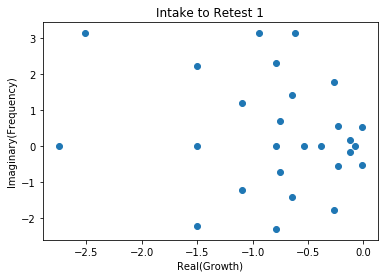

In [41]:
#plot real and imaginary parts of the log of the eigenvalues
plt.scatter(Y1R1_eiglog.real,Y1R1_eiglog.imag)
plt.title('Intake to Retest 1') 
plt.xlabel('Real(Growth)')
plt.ylabel('Imaginary(Frequency)')
plt.show()

In [42]:
#largest log eigenvalue
max(Y1R1_eiglog)

(-0.016910172610905178+0.5283867791097773j)

In [43]:
#for lambda*norm of eigenvector : is lambda only the real part? or is its absolute value?
Y1R1_lamphi=np.zeros(27)

for i in range (27):
    rep=y[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(x[i])*norm
    Y1R1_lamphi[i]=val
Y1R1_lamphi  

array([1.13980423, 0.93694349, 0.28723679, 0.61884226, 0.39470842,
       0.28029778, 0.52373831, 0.30605087, 0.34690084, 0.5133255 ,
       0.83698641, 0.73454867, 0.84783088, 0.67944496, 0.88060554,
       0.68382713, 0.59788335, 0.83177165, 0.82732655, 0.47458291,
       0.59589002, 0.38012931, 0.09239449, 0.13150267, 0.04736438,
       0.04554893, 0.06322118])

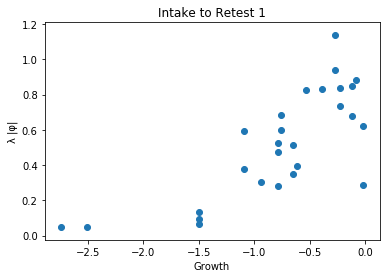

In [44]:
#plot of real part of log(eigenvalue) vs lambda*eigenvector
plt.scatter(Y1R1_eiglog.real,Y1R1_lamphi)
plt.title('Intake to Retest 1') 
plt.xlabel('Growth')
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

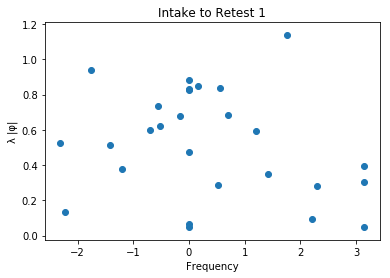

In [45]:
#plot of imaginary part of log(eigenvalue) vs lambda*eigenvector
plt.scatter(Y1R1_eiglog.imag,Y1R1_lamphi)
plt.title('Intake to Retest 1') 
plt.xlabel('Frequency')
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

In [46]:
#sort the eigenvalues and eigenvectors accordingly from Y1 to R1

idx = np.lexsort((x.imag, x.real))[::-1]   
x = x[idx]
y = y[:,idx]

In [47]:
print(x)

[ 0.92329352+0.j          0.87537496+0.14193444j  0.87537496-0.14193444j
  0.84914028+0.49568735j  0.84914028-0.49568735j  0.68019342+0.j
  0.67628424+0.4233194j   0.67628424-0.4233194j   0.58414871+0.j
  0.45617584+0.j          0.35734314+0.30494544j  0.35734314-0.30494544j
  0.22299163+0.j          0.11919064+0.31410248j  0.11919064-0.31410248j
  0.07803871+0.51717382j  0.07803871-0.51717382j  0.06428753+0.j
 -0.08123082+0.j         -0.13502619+0.17809015j -0.13502619-0.17809015j
 -0.14969816+0.74929203j -0.14969816-0.74929203j -0.30700879+0.33767123j
 -0.30700879-0.33767123j -0.39165872+0.j         -0.53972558+0.j        ]


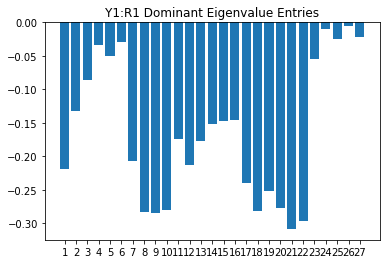

In [48]:
#plot of the entries for each component in the dominant eigenvalue
index=np.zeros(27)
weiabs=np.zeros(27)
for i in range (27):
    index[i]=i+1
for j in range (27):
    weiabs[j]=y[j,0]
plt.bar(index,weiabs)
plt.title('Y1:R1 Dominant Eigenvalue Entries') 
plt.xticks(np.arange(min(index), max(index)+1, 1.0))
plt.show()

There are negative entries within the dominant eigenvalue. What does this mean?

### R1 to R2

In [117]:
#SVD for R1
U_R1,Sig_R1,V_R1_T=np.linalg.svd(R1, full_matrices=False)
U_R1_T=U_R1.conjugate().transpose()
V_R1=V_R1_T.conjugate().transpose()
Sig_inv_R1=np.zeros((27, 27))
for i in range(27):
    for j in range(27):
        if i==j:
            Sig_inv_R1[i][j]=1/Sig_R1[i]


In [131]:
#A matrix: R1 to R2
A_step1=np.dot(R2, V_R1)
A_step2=np.dot(A_step1,Sig_inv_R1)
A_R1_R2=np.dot(A_step2,U_R1_T)
#A_R1_R2

In [120]:
#produce eigenvalues/eigenvectors 
m,n=np.linalg.eig(A_R1_R2)

In [130]:
#print(A_R1_R2)

In [121]:
#take log of eigenvalues
R1R2_eiglog=np.log(m)

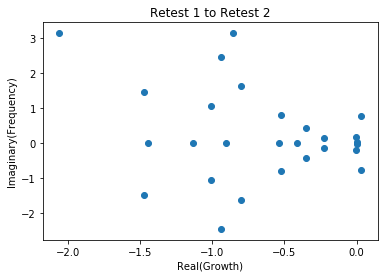

In [122]:
#plot real and imaginary parts of the log of the eigenvalues
plt.scatter(R1R2_eiglog.real,R1R2_eiglog.imag)
plt.title('Retest 1 to Retest 2') 
plt.xlabel('Real(Growth)')
plt.ylabel('Imaginary(Frequency)')
plt.show()

In [123]:
#for lambda*norm of eigenvector : is lambda only the real part? or is its absolute value?
R1R2_lamphi=np.zeros(27)

for i in range (27):
    rep=n[i]
    norm=np.linalg.norm(rep)
    val=np.absolute(m[i])*norm
    R1R2_lamphi[i]=val
R1R2_lamphi    

array([1.90469346, 1.53943491, 0.18734466, 0.17413298, 0.14106277,
       0.40252253, 0.97262916, 1.44369109, 1.2599181 , 0.48259449,
       0.51351397, 0.67066965, 0.48761742, 0.1600384 , 0.21077351,
       0.22532425, 0.37756409, 0.40987629, 0.78707774, 0.7169347 ,
       0.9475871 , 0.75605847, 0.08031778, 0.20079676, 0.22822855,
       0.34724884, 0.31164843])

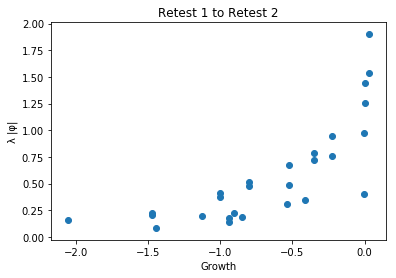

In [124]:
#plot of real part of log(eigenvalue) vs lambda*eigenvector
plt.scatter(R1R2_eiglog.real,R1R2_lamphi)
plt.title('Retest 1 to Retest 2') 
plt.xlabel('Growth')
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

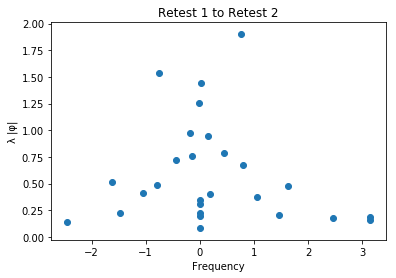

In [125]:
#plot of imaginary part of log(eigenvalue) vs lambda*eigenvector
plt.scatter(R1R2_eiglog.imag,R1R2_lamphi)
plt.title('Retest 1 to Retest 2') 
plt.xlabel('Frequency')
plt.ylabel(u'\u03BB' ' |' u'\u03C6''|')
plt.show()

In [126]:
#sort the eigenvalues and eigenvectors accordingly from R1 to R2

idx = np.lexsort((m.imag, m.real))[::-1]   
m = m[idx]
n = n[:,idx]

In [141]:
print(n)

[[ 5.74797607e-01+0.00000000e+00j  5.74797607e-01-0.00000000e+00j
  -4.72883284e-01+0.00000000e+00j -4.72883284e-01-0.00000000e+00j
   5.79812190e-01+0.00000000e+00j  5.79812190e-01-0.00000000e+00j
  -1.37739958e-01-9.60198823e-02j -1.37739958e-01+9.60198823e-02j
   8.17727537e-01+0.00000000e+00j  5.61051433e-02+9.02290296e-02j
   5.61051433e-02-9.02290296e-02j  3.07701139e-01+0.00000000e+00j
  -3.77572485e-02+1.03463092e-01j -3.77572485e-02-1.03463092e-01j
   3.55780402e-01+0.00000000e+00j  1.99231673e-01+0.00000000e+00j
  -2.13436595e-01+0.00000000e+00j  3.94766838e-03+1.39483554e-01j
   3.94766838e-03-1.39483554e-01j -1.89846157e-01-1.39945775e-01j
  -1.89846157e-01+1.39945775e-01j -3.04182012e-01-1.58834153e-01j
  -3.04182012e-01+1.58834153e-01j  3.11774167e-01+0.00000000e+00j
  -7.80411985e-02+1.77515567e-02j -7.80411985e-02-1.77515567e-02j
  -2.10624129e-01+0.00000000e+00j]
 [ 3.31773355e-01+6.62258153e-03j  3.31773355e-01-6.62258153e-03j
  -1.67473081e-01-1.41437517e-01j -1.6747

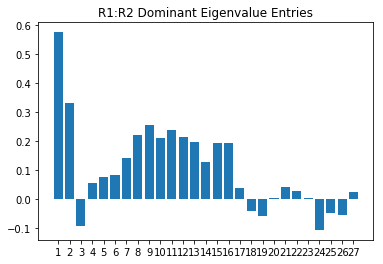

In [139]:
#plot of the entries for each component in the dominant eigenvalue
weiabs2=np.zeros(27)
for j in range (27):
    weiabs2[j]=n[j,0]
plt.bar(index,weiabs2)
plt.title('R1:R2 Dominant Eigenvalue Entries') 
plt.xticks(np.arange(min(index), max(index)+1, 1.0))
plt.show()

There are negative entries within the dominant eigenvalue. What does this mean?

<BarContainer object of 27 artists>

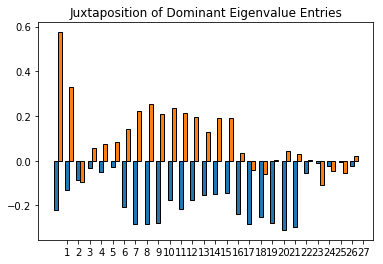

In [129]:
year = ['Y1 to R1','R1 to R2']
pos = pos = np.arange(len(index))
bar_width = 0.35
plt.title('Juxtaposition of Dominant Eigenvalue Entries') 
plt.xticks(np.arange(min(index), max(index)+1, 1.0))
plt.bar(pos,weiabs,bar_width,edgecolor='black')
plt.bar(pos+bar_width,weiabs2,bar_width,edgecolor='black')

## Blue: Y1 to R1 ; Orange: R1 to R2